In [2]:
try:
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten
    from pyspark.sql.types import ArrayType, StringType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce
except:
    print("downloading stuff...")
    %pip install pyspark
    %pip install pandas
    %pip install textblob
    %pip install matplotlib
    %pip install seaborn
    %pip install functools
    %pip install nltk
    %pip install findspark
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten
    from pyspark.sql.types import ArrayType, StringType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce

nltk.download('wordnet')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def show_pandas_df(spark_df, limit = None, *columns):
    if not columns:
        if limit is not None:
            return spark_df.limit(limit).toPandas()
        else:
            return spark_df.toPandas()
    else:
        return spark_df.select(*columns).limit(limit).toPandas()

In [4]:
findspark.init()
spark = SparkSession.builder \
    .appName("EiffelTowerTweetsAnalysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.network.timeout", "800s") \
    .config("spark.sql.shuffle.partitions", "2") \
    .config("spark.python.worker.reuse", "false") \
    .getOrCreate()


selected = spark.read.json("../../datasets/eiffel-tower-reviews.json").select('title', 'text')

show_pandas_df(selected, 10)

,title,text
0,Must do even it was so busy,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris
1,A Classic,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there."
2,Wet weather,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes."
3,Not to be missed,Visited with my wife and son.
4,Awesome!!!,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.
5,Iconic place for anyone visiting France,Dont hesitate and got all the way up to the top. The view is inspiring. Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset. Make sure to look at the tower from the streets (or Sena river) around 21:00 hours to see some extra lights !!!!!
6,Delightful,"I enjoyed the tower with my kids, and went to the top, beautiful views, with some lovely photos, an iconic building I had to see while there,"
7,Wonderful experience at night,Read through the history of the Eiffel Tower and enjoy it's magnificence twice - once during the day at close quarters and second at night. Wonderful going into history.
8,Wow,This by far was our favourite part of Europe. Nothing can compare to seeing this amazing piece of architecture in real life. It is simply breathtaking? Make this your number one priority on any trip to Europe
9,Great,Something you have to do when you visit Paris. Its a must ☺️. The views are breath taking. Really beautiful


### Limpando colunas

In [147]:
print(selected.count())
titles = selected.select('title').dropna()
texts = selected.select('text').dropna()
print(titles.count())
print(texts.count())


7179
7179
7176


In [148]:
def cleaner(column, column_name):
    return column.withColumn(str(column_name) + "_cleaned", regexp_replace(col(column_name), "[^a-zA-Z0-9 ]", ""))

texts = cleaner(texts, 'text')
show_pandas_df(texts, 10)

,text,text_cleaned
0,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris
1,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there.",My significant other and I drunkenly stumbled here a few weeks back For a cliche type experience it certainly was absolutely incredible We popped in around 2200 and the Tower was beautifully lit The view from the top is fantastic but be prepared to dress warm Definitely cold up there
2,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes.",We had a tour to the Eiffel Tower while we were in Paris Unfortunately one of the cable cars was down while there which made the wait times a little longer even with skip the queue passes
3,Visited with my wife and son.,Visited with my wife and son
4,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower It was very very beautiful to see the Eiffel all lit up beautifully At 10pm there is special illumination which ch starts and last for 5 mins Its like millions of leds starts blinking Covering the entire tower I was awe stuck to see the sight Must must go
5,Dont hesitate and got all the way up to the top. The view is inspiring. Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset. Make sure to look at the tower from the streets (or Sena river) around 21:00 hours to see some extra lights !!!!!,Dont hesitate and got all the way up to the top The view is inspiring Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset Make sure to look at the tower from the streets or Sena river around 2100 hours to see some extra lights
6,"I enjoyed the tower with my kids, and went to the top, beautiful views, with some lovely photos, an iconic building I had to see while there,",I enjoyed the tower with my kids and went to the top beautiful views with some lovely photos an iconic building I had to see while there
7,Read through the history of the Eiffel Tower and enjoy it's magnificence twice - once during the day at close quarters and second at night. Wonderful going into history.,Read through the history of the Eiffel Tower and enjoy its magnificence twice once during the day at close quarters and second at night Wonderful going into history
8,This by far was our favourite part of Europe. Nothing can compare to seeing this amazing piece of architecture in real life. It is simply breathtaking? Make this your number one priority on any trip to Europe,This by far was our favourite part of Europe Nothing can compare to seeing this amazing piece of architecture in real life It is simply breathtaking Make this your number one priority on any trip to Europe
9,Something you have to do when you visit Paris. Its a must ☺️. The views are breath taking. Really beautiful,Something you have to do when you visit Paris Its a must The views are breath taking Really beautiful


In [149]:
titles = cleaner(titles, 'title')
show_pandas_df(titles, 10)

,title,title_cleaned
0,Must do even it was so busy,Must do even it was so busy
1,A Classic,A Classic
2,Wet weather,Wet weather
3,Not to be missed,Not to be missed
4,Awesome!!!,Awesome
5,Iconic place for anyone visiting France,Iconic place for anyone visiting France
6,Delightful,Delightful
7,Wonderful experience at night,Wonderful experience at night
8,Wow,Wow
9,Great,Great


### Mais processo de limpeza
- pegando apenas as palavras nos textos e titulos
- removendo palavras comuns

In [150]:
def get_words(df, input_col, output_col):
    return Tokenizer(inputCol=input_col, outputCol=output_col).transform(df).select(output_col)

def remove_stop_words(df, input_col, output_col):
    return StopWordsRemover(inputCol=input_col, outputCol=output_col).transform(df).select(output_col)

def count_words(df):
    return df.groupBy("word").agg(count("word").alias("count")).orderBy("count", ascending=False)


not_filtered_text_words = get_words(texts, "text_cleaned", "words")
filtered_text_words = remove_stop_words(not_filtered_text_words, "words", "filtered_words")

not_filtered_title_words = get_words(titles, "title_cleaned", "words")
filtered_title_words = remove_stop_words(not_filtered_title_words, "words", "filtered_words")

# Exemplo
not_filtered_title_words.show()
filtered_title_words.show()

+--------------------+
|               words|
+--------------------+
|[must, do, even, ...|
|        [a, classic]|
|      [wet, weather]|
|[not, to, be, mis...|
|           [awesome]|
|[iconic, place, f...|
|        [delightful]|
|[wonderful, exper...|
|               [wow]|
|             [great]|
|                [ok]|
|[its, the, eiffel...|
|           [amazing]|
|[one, and, only, ...|
|[long, long, queu...|
|        [incredible]|
|[time, of, day, m...|
|[not, to, be, mis...|
|       [book, ahead]|
|           [amazing]|
+--------------------+
only showing top 20 rows

+--------------------+
|      filtered_words|
+--------------------+
|  [must, even, busy]|
|           [classic]|
|      [wet, weather]|
|            [missed]|
|           [awesome]|
|[iconic, place, a...|
|        [delightful]|
|[wonderful, exper...|
|               [wow]|
|             [great]|
|                [ok]|
|[eiffel, tower, s...|
|           [amazing]|
|       [one, eiffel]|
|[long, long, queu...|
|       

In [151]:
def explode_words(df, input_col):
    return df.select(explode(col(input_col)).alias("word")).filter(col("word") != "")

def count_words(df):
    return df.groupBy("word").agg(count("word").alias("count")).orderBy("count", ascending=False)

exploded_text_words = explode_words(filtered_text_words, "filtered_words")
text_word_counts = count_words(exploded_text_words)

exploded_title_words = explode_words(filtered_title_words, "filtered_words")
title_word_counts = count_words(exploded_title_words)

combined_word_counts = text_word_counts.union(title_word_counts)
final_word_counts = combined_word_counts.groupBy("word").agg(spark_sum("count").alias("total_count")).orderBy("total_count", ascending=False).limit(10)

final_df = show_pandas_df(final_word_counts)

In [152]:
def make_bar_plot(style, palette, figsize, x, y, data, title, xlabel, ylabel, fontsize):
    sns.set_style(style)  
    sns.set_palette(palette)

    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.show()

### Plot de palavras mais frequentes

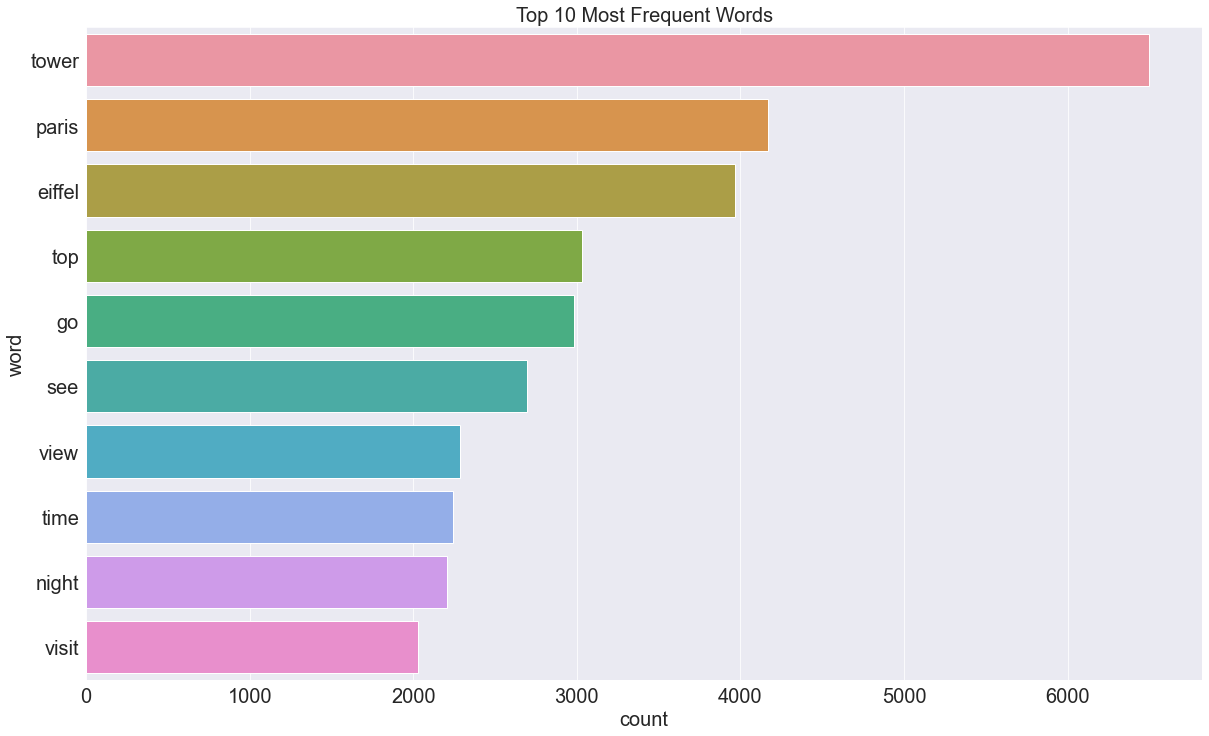

In [153]:
make_bar_plot("darkgrid", "viridis", (20,12), 'total_count', 'word', final_df, 'Top 10 Most Frequent Words', 'count', 'word', 20)

### Lematização não está funcionando

In [154]:
# lemmatizer = WordNetLemmatizer()

# @udf
# def lemmatize_tokens(tokens):
#     return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

# tokens_lemma = exploded_text_words.withColumn("words_lemmatized", lemmatize_tokens(exploded_text_words['word']))
# tokens_lemma.show()

In [155]:
def create_expressions(words_data, ngram_range, input_col, output_col = 'expressions'):
    words_list = words_data.select(collect_list(col(input_col)).alias(input_col))
    expressions = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        expressions.append(
            NGram(n=n, inputCol=input_col, outputCol=output_col) \
                .transform(words_list)
        )
    return reduce(lambda df1, df2: df1.union(df2), expressions)



In [156]:
text_expressions = create_expressions(exploded_text_words, (2, 4), 'word')
title_expressions = create_expressions(exploded_title_words, (2, 4), 'word')

# Exemplo
show_pandas_df(title_expressions, 10, 'expressions')

,expressions
0,"[must even, even busy, busy classic, classic wet, wet weather, weather missed, missed awesome, awesome iconic, iconic place, place anyone, anyone visiting, visiting france, france delightful, delightful wonderful, wonderful experience, experience night, night wow, wow great, great ok, ok eiffel, eiffel tower, tower surprises, surprises amazing, amazing one, one eiffel, eiffel long, long long, long queues, queues worth, worth end, end incredible, incredible time, time day, day matters, matters missed, missed book, book ahead, ahead amazing, amazing behind, behind bars, bars one, one tick, tick list, list dirty, dirty visiting, visiting eiffel, eiffel tower, tower mustdo, mustdo activity, activity paris, paris must, must see, see behind, behind scenes, scenes tour, tour bucket, bucket list, list beautiful, beautiful night, night view, view beautiful, beautiful view, view amazing, amazing always, always lunch, lunch jlejuesveni, jlejuesveni eiffel, eiffel tower, tower love, love resides, resides amazing, amazing heart, heart soul, soul paris, paris 1, 1 worth, worth look, look one, one towers, towers rest, rest lot, lot steel, steel wit, wit style, style book, book tickets, tickets advance, advance lovely, lovely evening, evening visit, visit better, better far, far away, away eiffel, eiffel tower, tower eiffel, eiffel tower, tower visit, visit stunning, stunning impressive, ...]"
1,"[must even busy, even busy classic, busy classic wet, classic wet weather, wet weather missed, weather missed awesome, missed awesome iconic, awesome iconic place, iconic place anyone, place anyone visiting, anyone visiting france, visiting france delightful, france delightful wonderful, delightful wonderful experience, wonderful experience night, experience night wow, night wow great, wow great ok, great ok eiffel, ok eiffel tower, eiffel tower surprises, tower surprises amazing, surprises amazing one, amazing one eiffel, one eiffel long, eiffel long long, long long queues, long queues worth, queues worth end, worth end incredible, end incredible time, incredible time day, time day matters, day matters missed, matters missed book, missed book ahead, book ahead amazing, ahead amazing behind, amazing behind bars, behind bars one, bars one tick, one tick list, tick list dirty, list dirty visiting, dirty visiting eiffel, visiting eiffel tower, eiffel tower mustdo, tower mustdo activity, mustdo activity paris, activity paris must, paris must see, must see behind, see behind scenes, behind scenes tour, scenes tour bucket, tour bucket list, bucket list beautiful, list beautiful night, beautiful night view, night view beautiful, view beautiful view, beautiful view amazing, view amazing always, amazing always lunch, always lunch jlejuesveni, lunch jlejuesveni eiffel, jlejuesveni eiffel tower, eiffel tower love, tower love resides, love resides amazing, resides amazing heart, amazing heart soul, heart soul paris, soul paris 1, paris 1 worth, 1 worth look, worth look one, look one towers, one towers rest, towers rest lot, rest lot steel, lot steel wit, steel wit style, wit style book, style book tickets, book tickets advance, tickets advance lovely, advance lovely evening, lovely evening visit, evening visit better, visit better far, better far away, far away eiffel, away eiffel tower, eiffel tower eiffel, tower eiffel tower, eiffel tower visit, tower visit stunning, visit stunning impressive, stunning impressive romantic, ...]"
2,"[must even busy classic, even busy classic wet, busy classic wet weather, classic wet weather missed, wet weather missed awesome, weather missed awesome iconic, missed awesome iconic place, awesome iconic place anyone, iconic place anyone visiting, place anyone visiting france, anyone visiting france delightful, visiting france delightful wonderful, france delightful wonderful experience, delightful wonderful experience night, wonderful experience night wow, experience night wow great, night wow great ok, wow great o

In [157]:
new_text_expressions = text_expressions \
    .select("expressions") \
    .withColumn("expression", explode("expressions")) \
    .select("expression") \
    .groupBy("expression") \
    .count() \
    .orderBy(col("count").desc()) \
    # .limit(10)

new_title_expressions = title_expressions \
    .select("expressions") \
    .withColumn("expression", explode("expressions")) \
    .select("expression") \
    .groupBy("expression") \
    .count() \
    .orderBy(col("count").desc()) \
    # .limit(10)

top_expressions = new_text_expressions.union(new_title_expressions).groupBy("expression").agg(spark_sum("count").alias("total_count")).orderBy("total_count", ascending=False).limit(10)                 
top_expressions = show_pandas_df(top_expressions)
top_expressions

,expression,total_count
0,eiffel tower,3380
1,must see,793
2,go top,424
3,second floor,328
4,visit paris,288
5,well worth,279
6,second level,270
7,day night,268
8,see paris,264
9,visit eiffel,247


### Plot de expressões mais frequentes

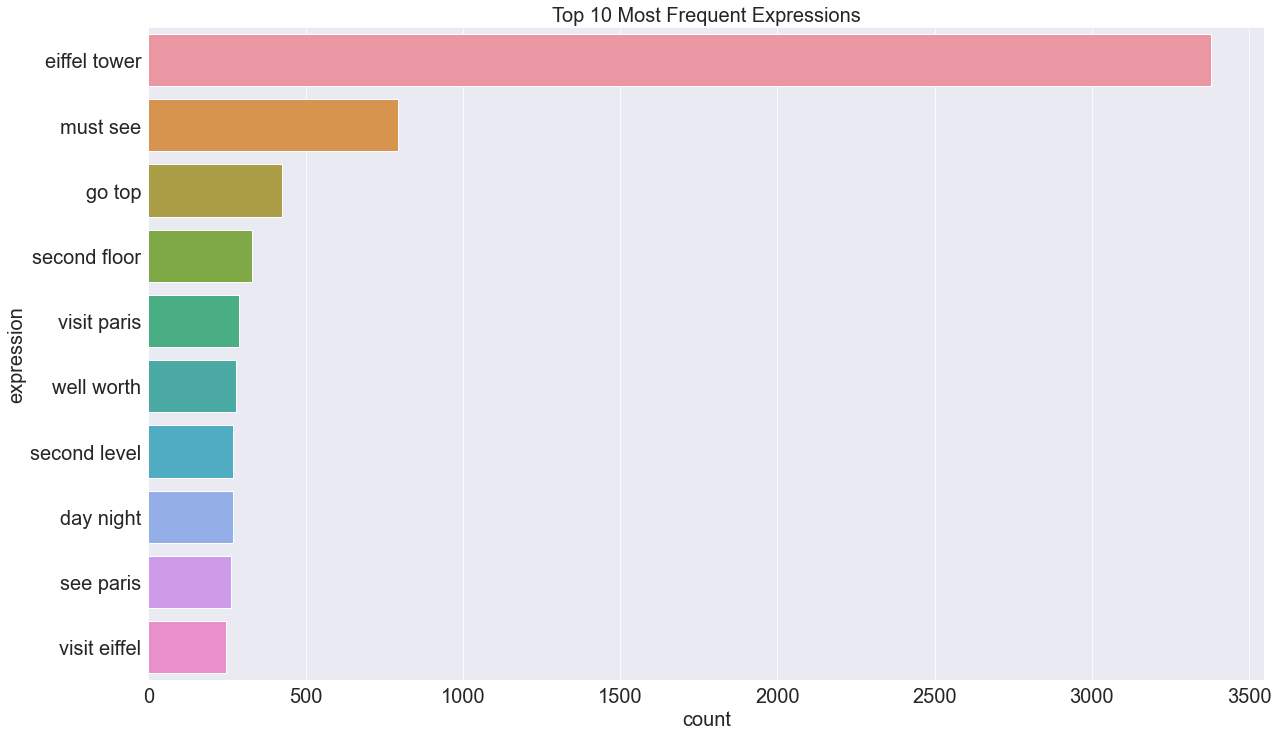

In [158]:
make_bar_plot("darkgrid", "viridis", (20,12), 'total_count', 'expression', top_expressions, 'Top 10 Most Frequent Expressions', 'count', 'expression', 20)

### Principais tópicos relacionados às revisões (incompleto)

In [159]:
vectorizer = CountVectorizer(inputCol="word", outputCol="characteristics")
text_words_list = exploded_text_words.select(collect_list(col('word')).alias('word'))
title_words_list = exploded_title_words.select(collect_list(col('word')).alias('word'))
words_list = text_words_list.union(title_words_list).select(array_distinct(flatten(collect_list("word"))).alias("word"))
vectorizer_model = vectorizer.fit(words_list)
characteristics = vectorizer_model.transform(words_list)
show_pandas_df(characteristics)

,word,characteristics
0,"[busiest, atttaction, paris, nice, restaurants, views, spectacular, top, must, significant, drunkenly, stumbled, weeks, back, cliche, type, experience, certainly, absolutely, incredible, popped, around, 2200, tower, beautifully, lit, view, fantastic, prepared, dress, warm, definitely, cold, tour, eiffel, unfortunately, one, cable, cars, made, wait, times, little, longer, even, skip, queue, passes, visited, wife, son, went, night, 10pm, see, illumination, beautiful, special, ch, starts, last, 5, mins, like, millions, leds, blinking, covering, entire, awe, stuck, sight, go, dont, hesitate, got, way, inspiring, early, morning, avoid, lines, late, afternoon, enjoy, sunset, make, sure, look, streets, sena, river, 2100, hours, extra, lights, enjoyed, kids, lovely, photos, ...]","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...)"


In [160]:
lda = LDA(k=10, maxIter=10, featuresCol="characteristics")
lda_model = lda.fit(characteristics)
topics = lda_model.describeTopics(5)
vocab = vectorizer_model.vocabulary
show_pandas_df(topics)

,topic,termIndices,termWeights
0,0,"[10633, 9683, 6879, 9974, 4408]","[0.00012500638108221265, 0.0001223262523646463, 0.00012004120959365772, 0.00011956454678765156, 0.00011941972552308367]"
1,1,"[7834, 680, 6740, 2406, 11255]","[0.00012208401622206032, 0.0001204983505002119, 0.00012026736013911202, 0.00011825961262414909, 0.00011802431402721743]"
2,2,"[9859, 3070, 7042, 1612, 3855]","[0.00012140009414462116, 0.00011851684172885913, 0.00011810739897543286, 0.00011799713442269974, 0.00011797005952723644]"
3,3,"[872, 4764, 8280, 9022, 11127]","[0.00012155644445452886, 0.0001210833691748182, 0.00012000358884850213, 0.00011984011598075812, 0.00011859906267656551]"
4,4,"[6280, 532, 6768, 10792, 7604]","[0.0001258597680816, 0.00012284361476793524, 0.00012221031072526302, 0.00012082383840788701, 0.00011985563405725011]"
5,5,"[238, 10918, 2708, 882, 5576]","[0.00012702351128285704, 0.00012077310360205856, 0.00012067903725902594, 0.00012040702729160817, 0.00011867780128200414]"
6,6,"[7556, 7906, 3352, 6835, 9157]","[0.00012580534205940987, 0.00012232812450375892, 0.00012220404035280906, 0.00012070326097261586, 0.00011793785880520399]"
7,7,"[8650, 4480, 2399, 8021, 9975]","[0.00013082361925921112, 0.0001230868266826315, 0.0001229645427287458, 0.00012186483895730087, 0.00012027185965822406]"
8,8,"[643, 1228, 7561, 8385, 6116]","[0.00012667692642492196, 0.00012007536001290458, 0.00011958290304217467, 0.0001192845949241673, 0.00011864326588159155]"
9,9,"[3310, 6762, 11458, 7797, 11347]","[0.00011870259443264825, 0.00011756960058110598, 0.00011738998480708893, 0.00011631542082369248, 0.00011620164300442284]"


### A partir daqui não funciona (rdd não funciona)

In [5]:
data = [("Alice", 34), ("Bob", 45), ("Charlie", 28)]
df = spark.createDataFrame(data, ["name", "age"])
rdd = df.rdd
print(rdd.collect().toDF("tokens"))

AttributeError: 'list' object has no attribute 'toDF'

In [6]:
spark.stop()